In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy             as np
import torch

from pprint import pprint

from toolbox  import detach, flatten, tensor, unflatten
from unidimensional import get_GUM_from_AB, sample_AB
from training import ABTrainingVisitor,               \
                     AggregateTrainingVisitor,        \
                     DefaultTrainingVisitor,          \
                     LossTrainingVisitor,             \
                     TalkativeTrainingVisitor,        \
                     parameters_estimation

from gum import HMM, RNN, GUM

from xmlot.misc.misc import gandalf

# Targetted GUM

In [2]:
n = 5

s = .2

a      = torch.randn((n, n))                * s
b      = torch.randn((1, n))                * s
c      = torch.randn((n ,1))                * s
eta_   = torch.randn((int(n * (n+1) / 2),)) * s
alpha_ = torch.randn((int(n * (n+1) / 2),)) * s
beta_  = torch.randn((1,))                  * s

unknown_gum = GUM(a, b, c, eta_, alpha_, beta_)

In [3]:
pprint(unknown_gum.theta)

(tensor([[-0.1887,  0.0175,  0.2502, -0.2343,  0.1066],
        [ 0.2977,  0.0406, -0.4540, -0.0227, -0.1596],
        [-0.0406,  0.0876, -0.2045, -0.0269,  0.0565],
        [-0.1416,  0.0013,  0.2573,  0.0691,  0.0529],
        [-0.0432,  0.1236, -0.2086,  0.4648,  0.0306]]),
 tensor([[ 0.0199, -0.0623,  0.1745,  0.0438,  0.3187]]),
 tensor([[ 0.1769],
        [ 0.0593],
        [-0.0024],
        [ 0.0615],
        [-0.1741]]),
 tensor([ 0.0907, -0.0691, -0.1320, -0.2553,  0.1273, -0.3569, -0.0277,  0.0063,
        -0.0331, -0.0250, -0.0358,  0.1225,  0.2078,  0.1151,  0.0296]),
 tensor([ 0.1273, -0.2485, -0.0376, -0.0799,  0.0473,  0.2468,  0.0027, -0.1375,
         0.3920, -0.1167, -0.1364,  0.1463, -0.1258, -0.1096, -0.1798]),
 tensor([-0.1502]))


In [4]:
len_samples     = 1000
size_data_train = 6000
size_data_test  = 100

data_train = [
    unknown_gum.sample(len_samples)[1] for _ in range(size_data_train)
]

data_test = [
    unknown_gum.sample(len_samples)[1]for _ in range(size_data_test)
]

In [5]:
data_train[0][-5:]

[tensor([[0.3725]]),
 tensor([[-0.5561]]),
 tensor([[0.1335]]),
 tensor([[0.2466]]),
 tensor([[-0.2603]])]

In [6]:
# Compute scores (RNN)
scores = []
for x in data_test:
    scores.append(detach(unknown_gum.negative_log_likelihood(x)))
        
print("GUM: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

unknown_gum_mean = np.mean(scores)
unknown_gum_std  = np.std(scores)

GUM: mean=0.5483376383781433, std=0.02198057621717453


# HMM and RNN initialisation
## Get models that generate a similar law

In [7]:
A0, B0 = sample_AB("hmm+rnn")

print("A={0}, B={1}".format(A0, B0))

hmm_uni = get_GUM_from_AB(A0, B0, submodel="hmm")
rnn_uni = get_GUM_from_AB(A0, B0, submodel="rnn")
gum_uni = get_GUM_from_AB(A0, B0)

A=0.882186592843047, B=0.4909424577259301



In [8]:
# Compute scores (HMM)
scores = []
for x in data_test:
    scores.append(detach(hmm_uni.negative_log_likelihood(x)))
        
print("HMM: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

# Compute scores (RNN)
scores = []
for x in data_test:
    scores.append(detach(rnn_uni.negative_log_likelihood(x)))
        
print("RNN: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

# Compute scores (GUM)
scores = []
for x in data_test:
    scores.append(detach(gum_uni.negative_log_likelihood(x)))
        
print("GUM: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

HMM: mean=0.8815414309501648, std=0.006935338489711285
RNN: mean=0.8821173310279846, std=0.006934971548616886
GUM: mean=0.8814694881439209, std=0.006935283541679382


## Expand dimensions

In [9]:
a       = torch.zeros((n, n))
a[0, 0] = hmm_uni.a

b       = torch.zeros((1, n))
b[0, 0] = hmm_uni.b

eta_    = torch.tensor([0. for _ in range(int(n * (n+1) / 2))])
eta_[0] = torch.sqrt(hmm_uni.eta_[0, 0])


alpha_    = torch.tensor([0. for _ in range(int(n * (n+1) / 2))])
alpha_[0] = torch.sqrt(hmm_uni.alpha_[0])

beta_ = hmm_uni.beta_

hmm = HMM(a, b, eta_, alpha_, beta_, requires_grad=True)

In [10]:
a       = torch.zeros((n, n))
a[0, 0] = rnn_uni.a

b       = torch.zeros((1, n))
b[0, 0] = rnn_uni.b

c       = torch.zeros((n, 1))
c[0, 0] = rnn_uni.c

beta_ = rnn_uni.beta_

rnn = RNN(a, b, c, beta_, requires_grad=True)

In [11]:
a       = torch.zeros((n, n))
a[0, 0] = gum_uni.a

b       = torch.zeros((1, n))
b[0, 0] = gum_uni.b

c       = torch.zeros((n, 1))
c[0, 0] = gum_uni.c

eta_    = torch.tensor([0. for _ in range(int(n * (n+1) / 2))])
eta_[0] = torch.sqrt(gum_uni.eta_[0, 0])


alpha_    = torch.tensor([0. for _ in range(int(n * (n+1) / 2))])
alpha_[0] = torch.sqrt(gum_uni.alpha_[0])

beta_ = gum_uni.beta_

gum = GUM(a, b, c, eta_, alpha_, beta_, requires_grad=True)

In [12]:
# Compute scores (HMM)
scores = []
for x in data_test:
    scores.append(detach(hmm.negative_log_likelihood(x)))
        
print("HMM: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

# Compute scores (RNN)
scores = []
for x in data_test:
    scores.append(detach(rnn.negative_log_likelihood(x)))
        
print("RNN: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

# Compute scores (GUM)
scores = []
for x in data_test:
    scores.append(detach(gum.negative_log_likelihood(x)))
        
print("GUM: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

HMM: mean=0.8815414309501648, std=0.006935338489711285
RNN: mean=0.8821173310279846, std=0.006934971548616886
GUM: mean=0.8814694881439209, std=0.006935283541679382


# Benchmark

In [13]:
def benchmark(
    model,
    data_train,
    data_test,
    size_batch,
    optimizer,
    scheduler,
):
    mean_scores = []
    std_scores  = []
    
    
    scores = []
    for x in data_test:
        scores.append(detach(model.negative_log_likelihood(x)))
    mean_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))
    
    print("0/{0}: mean={1}, std={2}".format(
        int(len(data_train) / size_batch)+1,
        mean_scores[-1],
        std_scores[-1]
    ))
    
    for i_ in range(int(len(data_train) / size_batch) + 1):
        i = i_ * size_batch
        batch = data_train[i:i+size_batch]
        for x in batch:           
            optimizer.zero_grad()

            # Compute gradients (w.r.t. our model)
            loss = model.negative_log_likelihood(x)
            loss.backward()

            # Update model's parameters
            optimizer.step()


        # Update learning rate
        scheduler.step()
        
        # Compute scores
        scores = []
        for x in data_test:
            scores.append(detach(model.negative_log_likelihood(x)))
        mean_scores.append(np.mean(scores))
        std_scores.append(np.std(scores))
        
        print("{0}/{1}: mean={2}, std={3}".format(
            i_+1,
            int(len(data_train) / size_batch)+1,
            mean_scores[-1],
            std_scores[-1]
        ))
        
        
    return mean_scores, std_scores

def _lr_(epoch, decays=[]):
    if epoch < len(decays):
        return decays[epoch]
    else:
        return 1

In [14]:
SIZE_BATCH = 10
LR         = 0.0001
DECAYS     = [] #1 for _ in range(1499)] + [.5]

In [15]:
size_batch = SIZE_BATCH

optimizer = torch.optim.Adam(hmm.theta, lr=LR)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: _lr_(e, decays=[]))

means_hmm, stds_hmm = benchmark(
    hmm,
    data_train,
    data_test,
    size_batch,
    optimizer,
    scheduler,
)

0/601: mean=0.8815414309501648, std=0.006935338489711285
1/601: mean=0.8798415660858154, std=0.006955619435757399
2/601: mean=0.878139317035675, std=0.0069760531187057495
3/601: mean=0.8764408826828003, std=0.006996565032750368
4/601: mean=0.8747413754463196, std=0.007017165422439575
5/601: mean=0.8730431199073792, std=0.007038007955998182
6/601: mean=0.8713445067405701, std=0.007058875635266304
7/601: mean=0.8696474432945251, std=0.007079863455146551
8/601: mean=0.8679532408714294, std=0.007100862916558981
9/601: mean=0.8662521243095398, std=0.007122243754565716
10/601: mean=0.864560604095459, std=0.007143606897443533
11/601: mean=0.8628697991371155, std=0.0071649812161922455
12/601: mean=0.8611860871315002, std=0.007186324335634708
13/601: mean=0.8594948053359985, std=0.007208098191767931
14/601: mean=0.8578048944473267, std=0.007229791022837162
15/601: mean=0.8561223745346069, std=0.007251814007759094
16/601: mean=0.8544355630874634, std=0.007273802068084478
17/601: mean=0.852748394

142/601: mean=0.6610508561134338, std=0.011449509300291538
143/601: mean=0.6597568392753601, std=0.011497327126562595
144/601: mean=0.6584684252738953, std=0.011545691639184952
145/601: mean=0.6571860313415527, std=0.011594338342547417
146/601: mean=0.6559126973152161, std=0.01164295431226492
147/601: mean=0.6546309590339661, std=0.011692710220813751
148/601: mean=0.6533622145652771, std=0.011742194183170795
149/601: mean=0.6520997881889343, std=0.011792082339525223
150/601: mean=0.6508423089981079, std=0.011842400766909122
151/601: mean=0.6495997905731201, std=0.011892511509358883
152/601: mean=0.6483457684516907, std=0.011943792924284935
153/601: mean=0.6470879912376404, std=0.011995751410722733
154/601: mean=0.6458375453948975, std=0.012048180215060711
155/601: mean=0.6446054577827454, std=0.01210012100636959
156/601: mean=0.6433833837509155, std=0.012152270413935184
157/601: mean=0.6421636343002319, std=0.012204800732433796
158/601: mean=0.6409389972686768, std=0.012258092872798443

282/601: mean=0.5549796223640442, std=0.020268522202968597
283/601: mean=0.5548291802406311, std=0.020317956805229187
284/601: mean=0.5546885132789612, std=0.020364835858345032
285/601: mean=0.5545448064804077, std=0.020415615290403366
286/601: mean=0.5544049143791199, std=0.02046523615717888
287/601: mean=0.5542923212051392, std=0.020503628998994827
288/601: mean=0.5541908144950867, std=0.02053619734942913
289/601: mean=0.5540792346000671, std=0.020575914531946182
290/601: mean=0.5539652109146118, std=0.020619221031665802
291/601: mean=0.5538352131843567, std=0.02067239210009575
292/601: mean=0.5537159442901611, std=0.02072194218635559
293/601: mean=0.5536047220230103, std=0.020770873874425888
294/601: mean=0.5534970760345459, std=0.020819827914237976
295/601: mean=0.5533886551856995, std=0.020869292318820953
296/601: mean=0.5532897710800171, std=0.02091449312865734
297/601: mean=0.5531991720199585, std=0.020955083891749382
298/601: mean=0.5531162619590759, std=0.020992744714021683
29

422/601: mean=0.5499783158302307, std=0.022165747359395027
423/601: mean=0.5499698519706726, std=0.02215801365673542
424/601: mean=0.5499613285064697, std=0.022161688655614853
425/601: mean=0.5499510765075684, std=0.02216516248881817
426/601: mean=0.5499405860900879, std=0.022158708423376083
427/601: mean=0.5499293208122253, std=0.022148478776216507
428/601: mean=0.5499187707901001, std=0.02215552143752575
429/601: mean=0.5499077439308167, std=0.022151105105876923
430/601: mean=0.5498982667922974, std=0.022143529728055
431/601: mean=0.5498893857002258, std=0.022142833098769188
432/601: mean=0.5498812198638916, std=0.02215910144150257
433/601: mean=0.549872636795044, std=0.022163575515151024
434/601: mean=0.5498626828193665, std=0.022151347249746323
435/601: mean=0.5498523116111755, std=0.02213321439921856
436/601: mean=0.5498425960540771, std=0.02212865650653839
437/601: mean=0.5498338937759399, std=0.02211681939661503
438/601: mean=0.5498242378234863, std=0.022116051986813545
439/601:

563/601: mean=0.5491988658905029, std=0.022147249430418015
564/601: mean=0.5491960048675537, std=0.022145118564367294
565/601: mean=0.5491920709609985, std=0.02213290147483349
566/601: mean=0.5491888523101807, std=0.0221153162419796
567/601: mean=0.5491859912872314, std=0.02211129292845726
568/601: mean=0.5491844415664673, std=0.02213115431368351
569/601: mean=0.5491832494735718, std=0.022146373987197876
570/601: mean=0.5491799712181091, std=0.02213720604777336
571/601: mean=0.5491740703582764, std=0.022087624296545982
572/601: mean=0.5491704344749451, std=0.022064190357923508
573/601: mean=0.549167811870575, std=0.022075045853853226
574/601: mean=0.5491668581962585, std=0.022106744349002838
575/601: mean=0.5491669774055481, std=0.022146260365843773
576/601: mean=0.5491652488708496, std=0.02215348370373249
577/601: mean=0.5491618514060974, std=0.022148072719573975
578/601: mean=0.5491580367088318, std=0.02213047631084919
579/601: mean=0.5491559505462646, std=0.022127972915768623
580/60

In [16]:
size_batch = SIZE_BATCH

optimizer = torch.optim.Adam(rnn.theta, lr=LR)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: _lr_(e, decays=[]))

means_rnn, stds_rnn = benchmark(
    rnn,
    data_train,
    data_test,
    size_batch,
    optimizer,
    scheduler,
)

0/601: mean=0.8821173310279846, std=0.006934971548616886
1/601: mean=0.8797456622123718, std=0.00695272721350193
2/601: mean=0.8773667812347412, std=0.006970974616706371
3/601: mean=0.8749874830245972, std=0.006989595014601946
4/601: mean=0.8726016283035278, std=0.007008581422269344
5/601: mean=0.8702093362808228, std=0.007027795538306236
6/601: mean=0.8678095936775208, std=0.007047315593808889
7/601: mean=0.8654035925865173, std=0.007067072205245495
8/601: mean=0.8629930019378662, std=0.007086965721100569
9/601: mean=0.8605700135231018, std=0.007107739802449942
10/601: mean=0.8581485152244568, std=0.007128350902348757
11/601: mean=0.8557217121124268, std=0.007149265613406897
12/601: mean=0.8532956838607788, std=0.007170144468545914
13/601: mean=0.8508563041687012, std=0.007192102260887623
14/601: mean=0.8484143614768982, std=0.007214758079499006
15/601: mean=0.8459731936454773, std=0.007237141486257315
16/601: mean=0.8435184955596924, std=0.007260194979608059
17/601: mean=0.8410568237

142/601: mean=0.5592202544212341, std=0.01811961829662323
143/601: mean=0.5584916472434998, std=0.0182732492685318
144/601: mean=0.5578103065490723, std=0.01842382363975048
145/601: mean=0.5571748614311218, std=0.018571021035313606
146/601: mean=0.5565894842147827, std=0.018714014440774918
147/601: mean=0.5560064911842346, std=0.01886349730193615
148/601: mean=0.5554798245429993, std=0.019006680697202682
149/601: mean=0.5549941062927246, std=0.019145771861076355
150/601: mean=0.5545455813407898, std=0.019281158223748207
151/601: mean=0.5541544556617737, std=0.019405946135520935
152/601: mean=0.5537540316581726, std=0.01954065077006817
153/601: mean=0.5533626675605774, std=0.019681284204125404
154/601: mean=0.5530099272727966, std=0.019816292449831963
155/601: mean=0.5527163147926331, std=0.01993628218770027
156/601: mean=0.5524566173553467, std=0.02004941925406456
157/601: mean=0.5522148013114929, std=0.0201619490981102
158/601: mean=0.5519764423370361, std=0.02028132602572441
159/601:

283/601: mean=0.5503290891647339, std=0.022086994722485542
284/601: mean=0.5503289699554443, std=0.022063108161091805
285/601: mean=0.5503292083740234, std=0.02206391468644142
286/601: mean=0.5503313541412354, std=0.022067930549383163
287/601: mean=0.550329327583313, std=0.02200726605951786
288/601: mean=0.5503346920013428, std=0.021930687129497528
289/601: mean=0.5503376722335815, std=0.02190246246755123
290/601: mean=0.5503366589546204, std=0.02190050110220909
291/601: mean=0.5503327250480652, std=0.021962713450193405
292/601: mean=0.5503313541412354, std=0.022003302350640297
293/601: mean=0.5503275394439697, std=0.022029776126146317
294/601: mean=0.5503254532814026, std=0.022056248039007187
295/601: mean=0.5503272414207458, std=0.022093720734119415
296/601: mean=0.5503281950950623, std=0.02210886962711811
297/601: mean=0.5503278970718384, std=0.02210519276559353
298/601: mean=0.5503259897232056, std=0.022086940705776215
299/601: mean=0.5503236651420593, std=0.02203313261270523
300/6

423/601: mean=0.5503218770027161, std=0.0220192838460207
424/601: mean=0.5503225326538086, std=0.022043202072381973
425/601: mean=0.5503222346305847, std=0.02207465097308159
426/601: mean=0.5503212809562683, std=0.022063035517930984
427/601: mean=0.550321102142334, std=0.02204013615846634
428/601: mean=0.550325334072113, std=0.022082360461354256
429/601: mean=0.5503284335136414, std=0.02207656018435955
430/601: mean=0.5503268241882324, std=0.02204941399395466
431/601: mean=0.5503255724906921, std=0.022047478705644608
432/601: mean=0.5503294467926025, std=0.02211073227226734
433/601: mean=0.5503305196762085, std=0.02212417870759964
434/601: mean=0.5503265261650085, std=0.02207292430102825
435/601: mean=0.550326406955719, std=0.022007502615451813
436/601: mean=0.5503281950950623, std=0.022001296281814575
437/601: mean=0.5503284931182861, std=0.021967455744743347
438/601: mean=0.5503302216529846, std=0.021983709186315536
439/601: mean=0.5503332018852234, std=0.022004107013344765
440/601: 

564/601: mean=0.5503405928611755, std=0.02217288129031658
565/601: mean=0.5503312945365906, std=0.022108228877186775
566/601: mean=0.5503209829330444, std=0.022029923275113106
567/601: mean=0.550319254398346, std=0.02201615460216999
568/601: mean=0.5503225922584534, std=0.022091353312134743
569/601: mean=0.5503244996070862, std=0.022134901955723763
570/601: mean=0.5503196120262146, std=0.022095391526818275
571/601: mean=0.5503215193748474, std=0.021943608298897743
572/601: mean=0.550330400466919, std=0.021900823339819908
573/601: mean=0.5503261089324951, std=0.02196728065609932
574/601: mean=0.5503225922584534, std=0.022083614021539688
575/601: mean=0.5503403544425964, std=0.022214986383914948
576/601: mean=0.5503385663032532, std=0.022214533761143684
577/601: mean=0.5503352284431458, std=0.022177958860993385
578/601: mean=0.5503237843513489, std=0.022096073254942894
579/601: mean=0.5503188967704773, std=0.022073300555348396
580/601: mean=0.5503263473510742, std=0.022124964743852615
58

In [17]:
size_batch = SIZE_BATCH

optimizer = torch.optim.Adam(gum.theta, lr=LR)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: _lr_(e, decays=[]))

means_gum, stds_gum = benchmark(
    gum,
    data_train,
    data_test,
    size_batch,
    optimizer,
    scheduler,
)

0/601: mean=0.8814694881439209, std=0.006935283541679382
1/601: mean=0.879931628704071, std=0.006944980472326279
2/601: mean=0.8783952593803406, std=0.006954899989068508
3/601: mean=0.8768649101257324, std=0.006964907981455326
4/601: mean=0.8753370642662048, std=0.006975107826292515
5/601: mean=0.8738127946853638, std=0.006985311862081289
6/601: mean=0.8722905516624451, std=0.006995565723627806
7/601: mean=0.8707712292671204, std=0.007006019353866577
8/601: mean=0.8692564964294434, std=0.0070163109339773655
9/601: mean=0.8677418231964111, std=0.007027044426649809
10/601: mean=0.8662343621253967, std=0.0070376102812588215
11/601: mean=0.8647304773330688, std=0.007048261351883411
12/601: mean=0.8632335662841797, std=0.007058749441057444
13/601: mean=0.8617362976074219, std=0.007069853134453297
14/601: mean=0.8602446913719177, std=0.007080966606736183
15/601: mean=0.8587595224380493, std=0.007092032581567764
16/601: mean=0.8572734594345093, std=0.007103359326720238
17/601: mean=0.85579085

142/601: mean=0.6962299942970276, std=0.009525076486170292
143/601: mean=0.695131778717041, std=0.00955392885953188
144/601: mean=0.6940388679504395, std=0.009583113715052605
145/601: mean=0.6929508447647095, std=0.009612679481506348
146/601: mean=0.6918650269508362, std=0.00964218471199274
147/601: mean=0.6907752156257629, std=0.00967231672257185
148/601: mean=0.689689576625824, std=0.00970231369137764
149/601: mean=0.6886086463928223, std=0.009732619859278202
150/601: mean=0.6875303387641907, std=0.009763156995177269
151/601: mean=0.6864599585533142, std=0.009793600998818874
152/601: mean=0.6853825449943542, std=0.009824829176068306
153/601: mean=0.6843000054359436, std=0.009856241755187511
154/601: mean=0.6832227110862732, std=0.009888013824820518
155/601: mean=0.6821537017822266, std=0.009919539093971252
156/601: mean=0.6810896992683411, std=0.009951239451766014
157/601: mean=0.6800246238708496, std=0.009983033873140812
158/601: mean=0.6789534687995911, std=0.01001518964767456
159/

282/601: mean=0.5729283690452576, std=0.015866247937083244
283/601: mean=0.5723722577095032, std=0.015928220003843307
284/601: mean=0.5718291997909546, std=0.01598980650305748
285/601: mean=0.5712826251983643, std=0.016052931547164917
286/601: mean=0.5707408785820007, std=0.016116183251142502
287/601: mean=0.5702359676361084, std=0.01617622934281826
288/601: mean=0.5697466731071472, std=0.01623494178056717
289/601: mean=0.5692455172538757, std=0.016296064481139183
290/601: mean=0.5687428116798401, std=0.016358694061636925
291/601: mean=0.5682187080383301, std=0.016424717381596565
292/601: mean=0.5677106380462646, std=0.016489973291754723
293/601: mean=0.5672141909599304, std=0.01655522920191288
294/601: mean=0.5667233467102051, std=0.01662093587219715
295/601: mean=0.5662322044372559, std=0.016687259078025818
296/601: mean=0.5657564401626587, std=0.01675259694457054
297/601: mean=0.5652948617935181, std=0.016816947609186172
298/601: mean=0.5648471713066101, std=0.016880586743354797
299

423/601: mean=0.5485804080963135, std=0.021889401599764824
424/601: mean=0.5485788583755493, std=0.021898996084928513
425/601: mean=0.5485779047012329, std=0.021909482777118683
426/601: mean=0.5485774874687195, std=0.021912764757871628
427/601: mean=0.5485777854919434, std=0.021913474425673485
428/601: mean=0.548577070236206, std=0.021926045417785645
429/601: mean=0.5485769510269165, std=0.021930329501628876
430/601: mean=0.5485767722129822, std=0.021931007504463196
431/601: mean=0.5485759973526001, std=0.021936019882559776
432/601: mean=0.5485746264457703, std=0.021952874958515167
433/601: mean=0.548573911190033, std=0.021961484104394913
434/601: mean=0.5485740900039673, std=0.021958500146865845
435/601: mean=0.5485745072364807, std=0.021951302886009216
436/601: mean=0.5485745072364807, std=0.02195337414741516
437/601: mean=0.5485745668411255, std=0.02194930426776409
438/601: mean=0.5485746264457703, std=0.02195350080728531
439/601: mean=0.5485747456550598, std=0.021957866847515106
44

564/601: mean=0.5485578179359436, std=0.022068435326218605
565/601: mean=0.5485572218894958, std=0.022060154005885124
566/601: mean=0.5485553741455078, std=0.022045493125915527
567/601: mean=0.5485550761222839, std=0.022042864933609962
568/601: mean=0.548555850982666, std=0.02206031233072281
569/601: mean=0.5485559701919556, std=0.02207271382212639
570/601: mean=0.5485551357269287, std=0.02206605300307274
571/601: mean=0.5485539436340332, std=0.022027745842933655
572/601: mean=0.5485545992851257, std=0.02201090380549431
573/601: mean=0.5485548377037048, std=0.022020112723112106
574/601: mean=0.5485546588897705, std=0.022044403478503227
575/601: mean=0.5485565066337585, std=0.022076964378356934
576/601: mean=0.5485565066337585, std=0.022083114832639694
577/601: mean=0.5485570430755615, std=0.022080793976783752
578/601: mean=0.5485557317733765, std=0.02206704020500183
579/601: mean=0.5485548377037048, std=0.022064153105020523
580/601: mean=0.5485562086105347, std=0.02207678183913231
581/

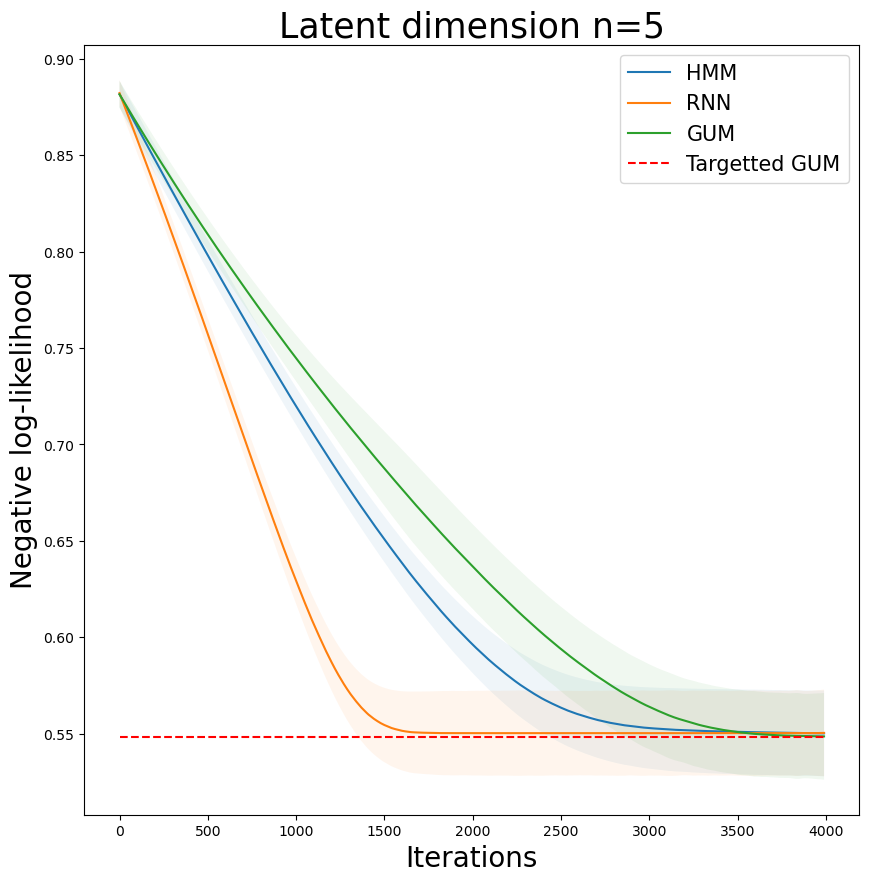

In [20]:
i = 400

means_hmm_ = means_hmm[:i]
stds_hmm_t = [m+s for m,s in zip(means_hmm_, stds_hmm[:len(means_hmm_)])]
stds_hmm_d = [m-s for m,s in zip(means_hmm_, stds_hmm[:len(means_hmm_)])]

means_rnn_ = means_rnn[:i]
stds_rnn_t = [m+s for m,s in zip(means_rnn_, stds_rnn[:len(means_rnn_)])]
stds_rnn_d = [m-s for m,s in zip(means_rnn_, stds_rnn[:len(means_rnn_)])]

means_gum_ = means_gum[:i]
stds_gum_t = [m+s for m,s in zip(means_gum_, stds_rnn[:len(means_gum_)])]
stds_gum_d = [m-s for m,s in zip(means_gum_, stds_rnn[:len(means_gum_)])]

means_unknown_gum_ = [unknown_gum_mean for _ in range(max(len(means_hmm_),len(means_rnn_)))]
x          = [x_*size_batch for x_ in range(len(means_unknown_gum_))]

plt.figure(figsize=(10, 10))

plt.plot(x, means_hmm_, label="HMM")
plt.fill_between(x, stds_hmm_d, stds_hmm_t, alpha=0.07)

plt.plot(x, means_rnn_, label="RNN")
plt.fill_between(x, stds_rnn_d, stds_rnn_t, alpha=0.07)

plt.plot(x, means_gum_, label="GUM")
plt.fill_between(x, stds_gum_d, stds_gum_t, alpha=0.07)



plt.plot(x, means_unknown_gum_, "r--", label="Targetted GUM")
plt.legend(fontsize=15)

plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Negative log-likelihood", fontsize=20)
plt.title("Latent dimension n={0}".format(n), fontsize=25)
plt.show()